<div class="alert alert-info">
<u><strong>Authors:</strong></u> <b>Alberto Vavassori</b> (alberto.vavassori@polimi.it), <b>Emanuele Capizzi</b> (emanuele.capizzi@polimi.it) - DICA - Politecnico di Milano - GIS GEOLab <br>
Developed within the LCZ-ODC project, funded by the Italian Space Agency (agreement n. 2022-30-HH.0).
</div>

# Co-registration of PRISMA imagery with Sentinel-2 imagery through GeFolki algorithm

This notebook is meant to co-register PRISMA imagery (SWIR and NIR data cubes) using Sentinel-2 pre-processed imagery as reference. <br> 
Co-registration is performed using the Ge-Folki algorithm (reference GitHub page for Geofolki algorithm: [Link](https://github.com/aplyer/gefolki)) which is based on Optical-Flow Computation.

<a id='TOC_TOP'></a>

The main steps implemented in this notebook are the following: <br>
 1. [opening PRISMA file (provided in .he5 format), reading and extracting image data](#sec1)  
 2. [importing the pre-processed Sentinel-2 image clipped to PRISMA image extent (i.e. result obtained through the notebook `1 - S2_Preprocessing.ipynb`) and resample it at 30m resolution](#sec2)
 3. [application of GeFolki algorithm](#sec3)  
 4. [exporting the original non co-registered PRISMA bands (RGB composite and all NIR/SWIR bands) as well as the co-registered PRISMA bands (RGB composite and all NIR/SWIR bands); the bands combinations are exported in GeoTIFF](#sec4)
 5. [Panchromatic coregistration and export](#sec5)
<hr>

## 1. <a id='sec1'></a>Opening PRISMA file, reading and extracting image data

**REQUIREMENT**: installation of [***h5py***](https://docs.h5py.org/en/stable/quick.html) library from command line with `pip install h5py`.
Libraries required for running the code:
- `h5py`
- `numpy`
- `matplotlib`
- `rasterio`
- `os`
- `pylab`
- `ipwidgets`
- GeFolki functionalities (`EFolki` and `wrapData`)

In [1]:
#Import libraries
import h5py
import numpy as np
import rasterio as rio
from rasterio.plot import show, show_hist
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pylab as pl
import os
import ipywidgets as widgets

# Import Gefolki functionalities
import sys
sys.path.append('python')
from algorithm import EFolki
from tools import wrapData

# Import functions and set auto-reload
from functions import *
%load_ext autoreload
%autoreload 2

# Create the folder/directory if it doesn't exist
if not os.path.exists('PRISMA_outputs'):
    os.makedirs('PRISMA_outputs')

Open the file containing the **PRISMA** image (.he5 file) and **Sentinel-2** to be processed:

In [2]:
date_s2_w = widgets.Dropdown(
    options=['2023-02-10', '2023-03-22', '2023-04-26', '2023-06-25', '2023-07-10', '2023-08-19'],
    value='2023-02-10',
    description='Sentinel-2 date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_s2_w

Dropdown(description='Sentinel-2 date:', layout=Layout(width='max-content'), options=('2023-02-10', '2023-03-2…

In [3]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10', '2023-08-08'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

Dropdown(description='PRISMA date:', layout=Layout(width='max-content'), options=('2023-02-09', '2023-03-22', …

In [4]:
sel_s2_date = date_s2_w.value
sel_prisma_date = date_prisma_w.value
print(f"The selected dates are --> Sentinel-2: {sel_s2_date} | PRISMA: {sel_prisma_date}.")

selected_image_s2 = get_s2_path('S2_outputs', sel_s2_date)
print(f"Selected Sentinel-2 image path --> {selected_image_s2}")
selected_image_prisma = get_PRISMA_path('imagery_S2_PRISMA', sel_prisma_date)
print(f"Selected PRISMA image path --> {selected_image_prisma}")

The selected dates are --> Sentinel-2: 2023-02-10 | PRISMA: 2023-02-09.
Selected Sentinel-2 image path --> S2_outputs\S2_20230210_20m_clip.tif
Selected PRISMA image path --> imagery_S2_PRISMA\PRS_L2D_STD_20230209102412_20230209102416_0001.he5


In [6]:
f = h5py.File(selected_image_prisma, 'r')

Print the list of keys. Each key can be accessed to explore the image metadata:

In [7]:
list(f.keys())

['HDFEOS', 'HDFEOS INFORMATION', 'Info', 'KDP_AUX']

(Optionally) it is possible to read names and values for root attributes (metadata contained in `HDF5` root):

In [8]:
# for attribute in f.attrs:
#     print(attribute,f.attrs[attribute])

(Optionally) it is possible to read the names for all attributes (metadata) contained in the `HDF5` Groups. Specific method for reading the values shall be built depending on the specific metadata type (a single value, an array, a matrix, etc):

In [9]:
# def printname(name):
#     print(name)

# f.visit(printname)

List the band wavelengths available in the VNIR cube:

In [10]:
vnir_bands = f.attrs['List_Cw_Vnir']
vnir_bands

array([  0.     ,   0.     ,   0.     , 977.3654 , 967.0267 , 956.2715 ,
       944.6273 , 934.11206, 923.9502 , 913.44507, 902.80164, 892.08093,
       881.45605, 870.74255, 859.97314, 849.20996, 838.5272 , 827.9195 ,
       817.31104, 806.71106, 796.127  , 785.65955, 775.2735 , 764.85645,
       754.4696 , 744.14954, 733.9552 , 723.87994, 713.72687, 703.737  ,
       694.12836, 684.13727, 674.46436, 664.8941 , 655.41876, 645.9638 ,
       636.6763 , 627.77844, 618.72   , 609.9582 , 601.0144 , 592.339  ,
       583.8441 , 575.4868 , 567.2061 , 559.02026, 550.9146 , 542.88513,
       535.05255, 527.3053 , 519.54376, 512.0464 , 504.51172, 497.05865,
       489.79486, 482.54816, 475.31885, 468.09842, 460.73175, 453.38947,
       446.0147 , 438.6569 , 431.3347 , 423.78476, 415.839  , 406.9934 ],
      dtype=float32)

List the band wavelengths available in the SWIR cube:

In [11]:
swir_bands = f.attrs['List_Cw_Swir']
swir_bands

array([2497.1155, 2490.2192, 2483.793 , 2477.055 , 2469.6272, 2463.0303,
       2456.5857, 2449.1423, 2442.403 , 2435.5442, 2428.6677, 2421.2373,
       2414.3567, 2407.6045, 2400.036 , 2393.0388, 2386.0618, 2378.771 ,
       2371.5522, 2364.5945, 2357.2937, 2349.7915, 2342.8228, 2335.5264,
       2327.8242, 2320.8955, 2313.2007, 2305.7227, 2298.6094, 2290.8267,
       2283.4934, 2276.0537, 2268.2883, 2260.8665, 2253.1104, 2245.4485,
       2237.904 , 2230.0076, 2222.4263, 2214.625 , 2206.843 , 2199.1353,
       2191.1003, 2183.4202, 2175.3442, 2167.4849, 2159.564 , 2151.3862,
       2143.4656, 2135.5103, 2127.3372, 2119.2314, 2111.039 , 2102.8213,
       2094.6252, 2086.3823, 2077.9915, 2069.7957, 2061.3787, 2053.0078,
       2044.6809, 2036.2607, 2027.7267, 2019.3214, 2010.6614, 2002.1106,
       1993.5482, 1984.853 , 1976.013 , 1967.3418, 1958.6244, 1949.9008,
       1941.1107, 1932.2599, 1923.3857, 1914.3015, 1904.9347, 1896.0913,
       1887.081 , 1878.7426, 1868.1732, 1859.5587, 

In [12]:
print(f"Number of VNIR Bands: {len(vnir_bands)}")

Number of VNIR Bands: 66


In [13]:
print(f"Number of SWIR Bands: {len(swir_bands)}")

Number of SWIR Bands: 173


Bands are stored in the two data cubes from larger to smaller wavelengths, but it is preferable to have them stored inversely. <br>
Therefore, a dictionary is created with keys containing the band number and value containing the wavelength. The first band has the smallest key:

In [14]:
vnir_dict = {}

for i, band in enumerate(vnir_bands):
    vnir_dict[len(vnir_bands) - i] = band

print(vnir_dict)

{66: 0.0, 65: 0.0, 64: 0.0, 63: 977.3654, 62: 967.0267, 61: 956.2715, 60: 944.6273, 59: 934.11206, 58: 923.9502, 57: 913.44507, 56: 902.80164, 55: 892.08093, 54: 881.45605, 53: 870.74255, 52: 859.97314, 51: 849.20996, 50: 838.5272, 49: 827.9195, 48: 817.31104, 47: 806.71106, 46: 796.127, 45: 785.65955, 44: 775.2735, 43: 764.85645, 42: 754.4696, 41: 744.14954, 40: 733.9552, 39: 723.87994, 38: 713.72687, 37: 703.737, 36: 694.12836, 35: 684.13727, 34: 674.46436, 33: 664.8941, 32: 655.41876, 31: 645.9638, 30: 636.6763, 29: 627.77844, 28: 618.72, 27: 609.9582, 26: 601.0144, 25: 592.339, 24: 583.8441, 23: 575.4868, 22: 567.2061, 21: 559.02026, 20: 550.9146, 19: 542.88513, 18: 535.05255, 17: 527.3053, 16: 519.54376, 15: 512.0464, 14: 504.51172, 13: 497.05865, 12: 489.79486, 11: 482.54816, 10: 475.31885, 9: 468.09842, 8: 460.73175, 7: 453.38947, 6: 446.0147, 5: 438.6569, 4: 431.3347, 3: 423.78476, 2: 415.839, 1: 406.9934}


In [15]:
swir_dict = {}

for i, band in enumerate(swir_bands):
    swir_dict[len(swir_bands) - i] = band

print(swir_dict)

{173: 2497.1155, 172: 2490.2192, 171: 2483.793, 170: 2477.055, 169: 2469.6272, 168: 2463.0303, 167: 2456.5857, 166: 2449.1423, 165: 2442.403, 164: 2435.5442, 163: 2428.6677, 162: 2421.2373, 161: 2414.3567, 160: 2407.6045, 159: 2400.036, 158: 2393.0388, 157: 2386.0618, 156: 2378.771, 155: 2371.5522, 154: 2364.5945, 153: 2357.2937, 152: 2349.7915, 151: 2342.8228, 150: 2335.5264, 149: 2327.8242, 148: 2320.8955, 147: 2313.2007, 146: 2305.7227, 145: 2298.6094, 144: 2290.8267, 143: 2283.4934, 142: 2276.0537, 141: 2268.2883, 140: 2260.8665, 139: 2253.1104, 138: 2245.4485, 137: 2237.904, 136: 2230.0076, 135: 2222.4263, 134: 2214.625, 133: 2206.843, 132: 2199.1353, 131: 2191.1003, 130: 2183.4202, 129: 2175.3442, 128: 2167.4849, 127: 2159.564, 126: 2151.3862, 125: 2143.4656, 124: 2135.5103, 123: 2127.3372, 122: 2119.2314, 121: 2111.039, 120: 2102.8213, 119: 2094.6252, 118: 2086.3823, 117: 2077.9915, 116: 2069.7957, 115: 2061.3787, 114: 2053.0078, 113: 2044.6809, 112: 2036.2607, 111: 2027.7267, 1

The following indexes are corresponding to NIR, red, green and blue wavelenghts (Keep the same band notation as ENMAP plugin where these bands have this meaning):

In [16]:
# Index of NIR red, green and blue in the VNIR cube
idx_nir = 51
idx_red = 33
idx_green = 23
idx_blue = 11

print(f"NIR wvl: {vnir_dict[idx_nir]:.3f}, \nRed wvl: {vnir_dict[idx_red]:.3f}, \nGreen wvl: {vnir_dict[idx_green]:.3f}, \nBlue wvl: {vnir_dict[idx_blue]:.3f}")

NIR wvl: 849.210, 
Red wvl: 664.894, 
Green wvl: 575.487, 
Blue wvl: 482.548


Store the NIR and SWIR keys (band number) in two lists:

In [17]:
vnir_keys = list(vnir_dict.keys())
swir_keys = list(swir_dict.keys())

PRISMA images are stored in the inverse order. So we must obtain the position of the band in the cube (using its index) and use that position to extract the image:

In [18]:
# #Index of the NIR(849 nm - Band 51) Red (660.26361nm - Band 33), Blue (478.1763nm - Band 11), and Green (571.00281nm - Band 23) bands:
idx_nir_prisma = vnir_keys.index(idx_nir)
idx_red_prisma = vnir_keys.index(idx_red)
idx_green_prisma = vnir_keys.index(idx_green)
idx_blue_prisma = vnir_keys.index(idx_blue)
print(f"The NIR band number {idx_nir} has position {idx_nir_prisma}")
print(f"The Red band number {idx_red} has position {idx_red_prisma}")
print(f"The Green band number {idx_green} has position {idx_green_prisma}")
print(f"The Blue band number {idx_blue} has position {idx_blue_prisma}")

The NIR band number 51 has position 15
The Red band number 33 has position 33
The Green band number 23 has position 43
The Blue band number 11 has position 55


Let's read and store attributes and wavelengths (_needed to choose the specific bands_) in separate arrays:

In [19]:
# Attributes
attrs = f.attrs

# Wavelengths (separately for VNIR and SWIR)
vn_wvl = np.array([wvl for wvl in attrs['List_Cw_Vnir']])
sw_wvl = np.array([wvl for wvl in attrs['List_Cw_Swir']])

# #Index of the Red (660.26361nm - Band 33), Blue (478.1763nm - Band 11), and Green (571.00281nm - Band 23) bands:
# idx_red = np.where(vn_wvl == 664.8941)[0][0]
# idx_blue = np.where(vn_wvl == 475.31885)[0][0]
# idx_green = np.where(vn_wvl == 575.4868)[0][0]

In [20]:
vn_wvl

array([  0.     ,   0.     ,   0.     , 977.3654 , 967.0267 , 956.2715 ,
       944.6273 , 934.11206, 923.9502 , 913.44507, 902.80164, 892.08093,
       881.45605, 870.74255, 859.97314, 849.20996, 838.5272 , 827.9195 ,
       817.31104, 806.71106, 796.127  , 785.65955, 775.2735 , 764.85645,
       754.4696 , 744.14954, 733.9552 , 723.87994, 713.72687, 703.737  ,
       694.12836, 684.13727, 674.46436, 664.8941 , 655.41876, 645.9638 ,
       636.6763 , 627.77844, 618.72   , 609.9582 , 601.0144 , 592.339  ,
       583.8441 , 575.4868 , 567.2061 , 559.02026, 550.9146 , 542.88513,
       535.05255, 527.3053 , 519.54376, 512.0464 , 504.51172, 497.05865,
       489.79486, 482.54816, 475.31885, 468.09842, 460.73175, 453.38947,
       446.0147 , 438.6569 , 431.3347 , 423.78476, 415.839  , 406.9934 ],
      dtype=float32)

Let's store the pixel coordinates (latitude and longitude) in two arrays (lat, lon):

In [21]:
data = f['HDFEOS']['SWATHS']['PRS_L2D_HCO']

lat = np.array(data['Geolocation Fields']['Latitude'][:])
lon = np.array(data['Geolocation Fields']['Longitude'][:])

Let's get the spectral information of each data cube and correct the dimensions of the arrays to get depth as the third dimension:

In [22]:
vrf = np.array(data['Data Fields']['VNIR_Cube'][:]) 
srf = np.array(data['Data Fields']['SWIR_Cube'][:]) 
print(vrf.shape)
print(srf.shape)

(1206, 66, 1230)
(1206, 173, 1230)


In [23]:
#move the number of wavelengths to the last position:
vrf = np.moveaxis(vrf, 1, 2)
srf = np.moveaxis(srf, 1, 2)
print(vrf.shape)
print(srf.shape)

(1206, 1230, 66)
(1206, 1230, 173)


Let's now convert the values stored in the data cubes from DN to spectral reflectance. To do so, we need to access the scaling factors availables among the attributes, namely `L2ScaleVnirMax` and `L2ScaleVnirMax` for the NIR cube, and `L2ScaleSwirMax` and `L2ScaleSwirMax` for the SWIR cube. Then, let's apply the formula provided in the documentation:


In [24]:
L2ScaleVnirMax = attrs['L2ScaleVnirMax']
L2ScaleVnirMin = attrs['L2ScaleVnirMin']
L2ScaleSwirMax = attrs['L2ScaleSwirMax']
L2ScaleSwirMin = attrs['L2ScaleSwirMin']
print(f"VNIR min: {L2ScaleVnirMin:.3f}, VNIR max: {L2ScaleVnirMax:.3f}")
print(f"SWIR min: {L2ScaleSwirMin:.3f}, SWIR max: {L2ScaleSwirMax:.3f}")

SR_scaler = 65535

vrf_refl = L2ScaleVnirMin + vrf*(L2ScaleVnirMax - L2ScaleVnirMin) / SR_scaler
srf_refl = L2ScaleSwirMin + srf*(L2ScaleSwirMax - L2ScaleSwirMin) / SR_scaler

VNIR min: 0.000, VNIR max: 0.986
SWIR min: 0.000, SWIR max: 1.000


Select the NIR, red, green, blue bands from the scaled VNIR cube, and plot them:

In [25]:
nir_band_prisma = vrf_refl[:, :, idx_nir_prisma]
red_band_prisma = vrf_refl[:, :, idx_red_prisma]
green_band_prisma = vrf_refl[:, :, idx_green_prisma]
blue_band_prisma = vrf_refl[:, :, idx_blue_prisma]

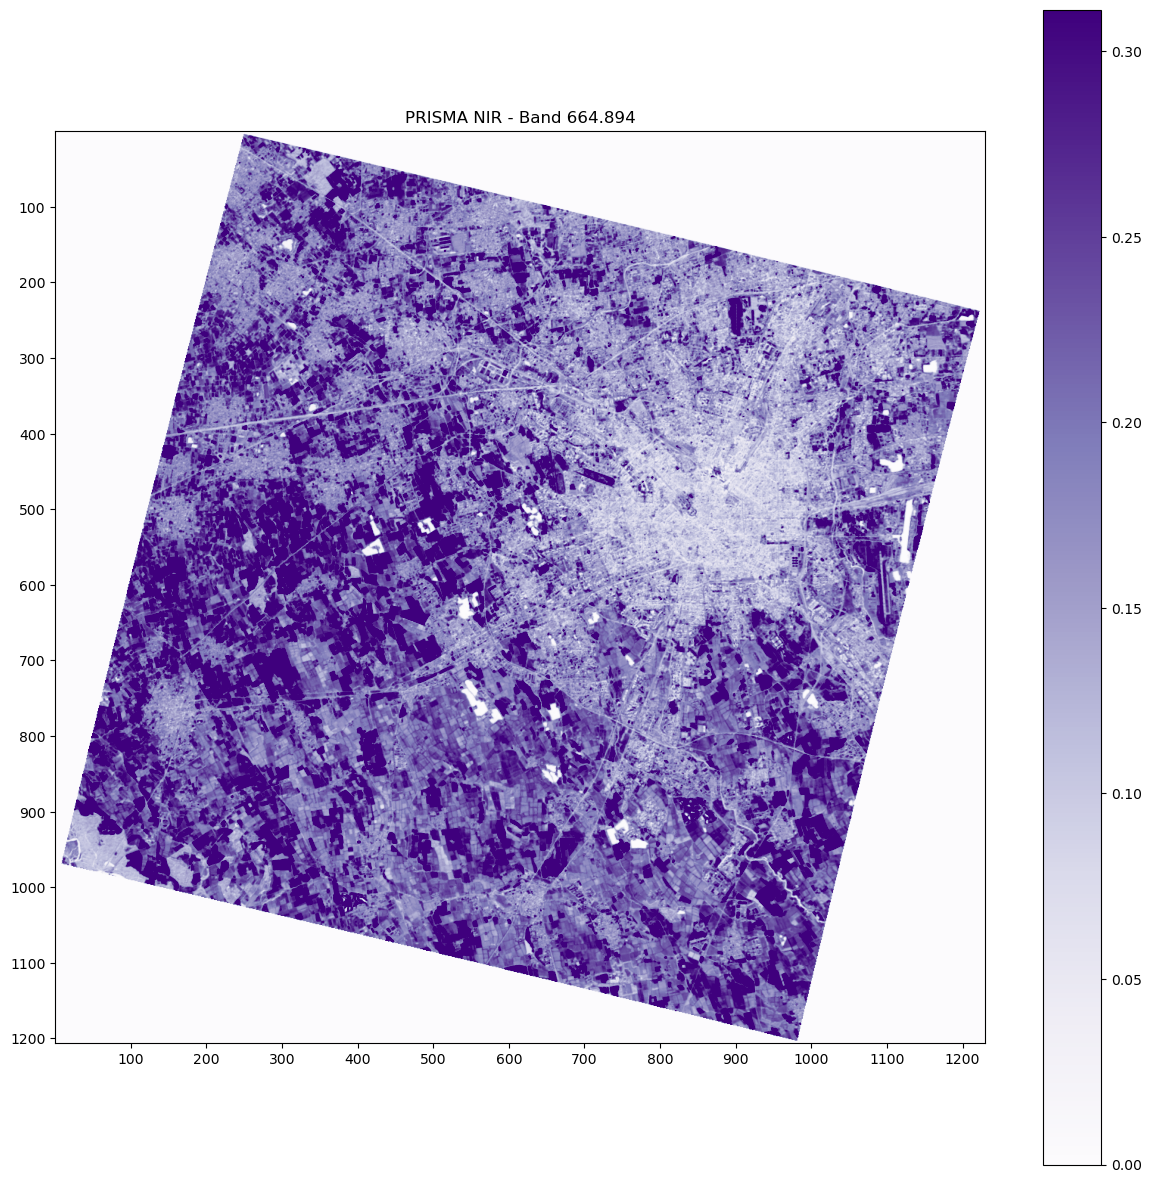

In [26]:
plt.figure(figsize = (15,15))
height, width = nir_band_prisma.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(nir_band_prisma, cmap="Purples", vmin=-np.quantile(nir_band_prisma, 0.1), vmax=np.quantile(nir_band_prisma, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title(f'PRISMA NIR - Band {vnir_dict[idx_red]:.3f}')
plt.colorbar()

'''NIR Band stored in a dedicated array'''
PRISMA_NirBand = nir_band_prisma

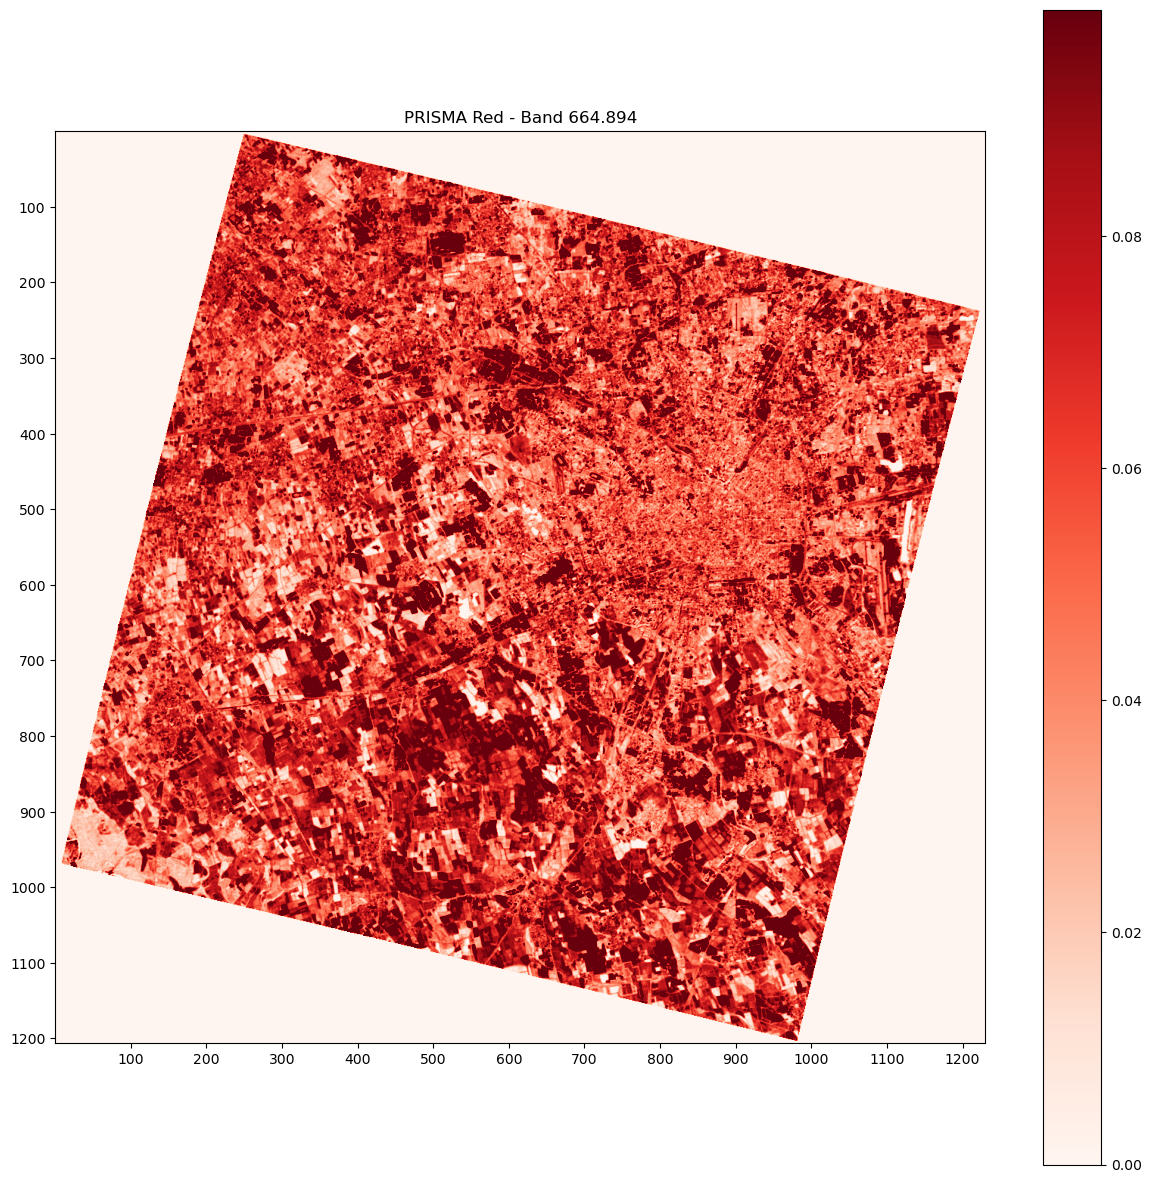

In [27]:
plt.figure(figsize = (15,15))
height, width = red_band_prisma.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(red_band_prisma, cmap="Reds", vmin=-np.quantile(red_band_prisma, 0.1), vmax=np.quantile(red_band_prisma, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title(f'PRISMA Red - Band {vnir_dict[idx_red]:.3f}')
plt.colorbar()

'''Red Band stored in a dedicated array'''
PRISMA_RedBand = red_band_prisma

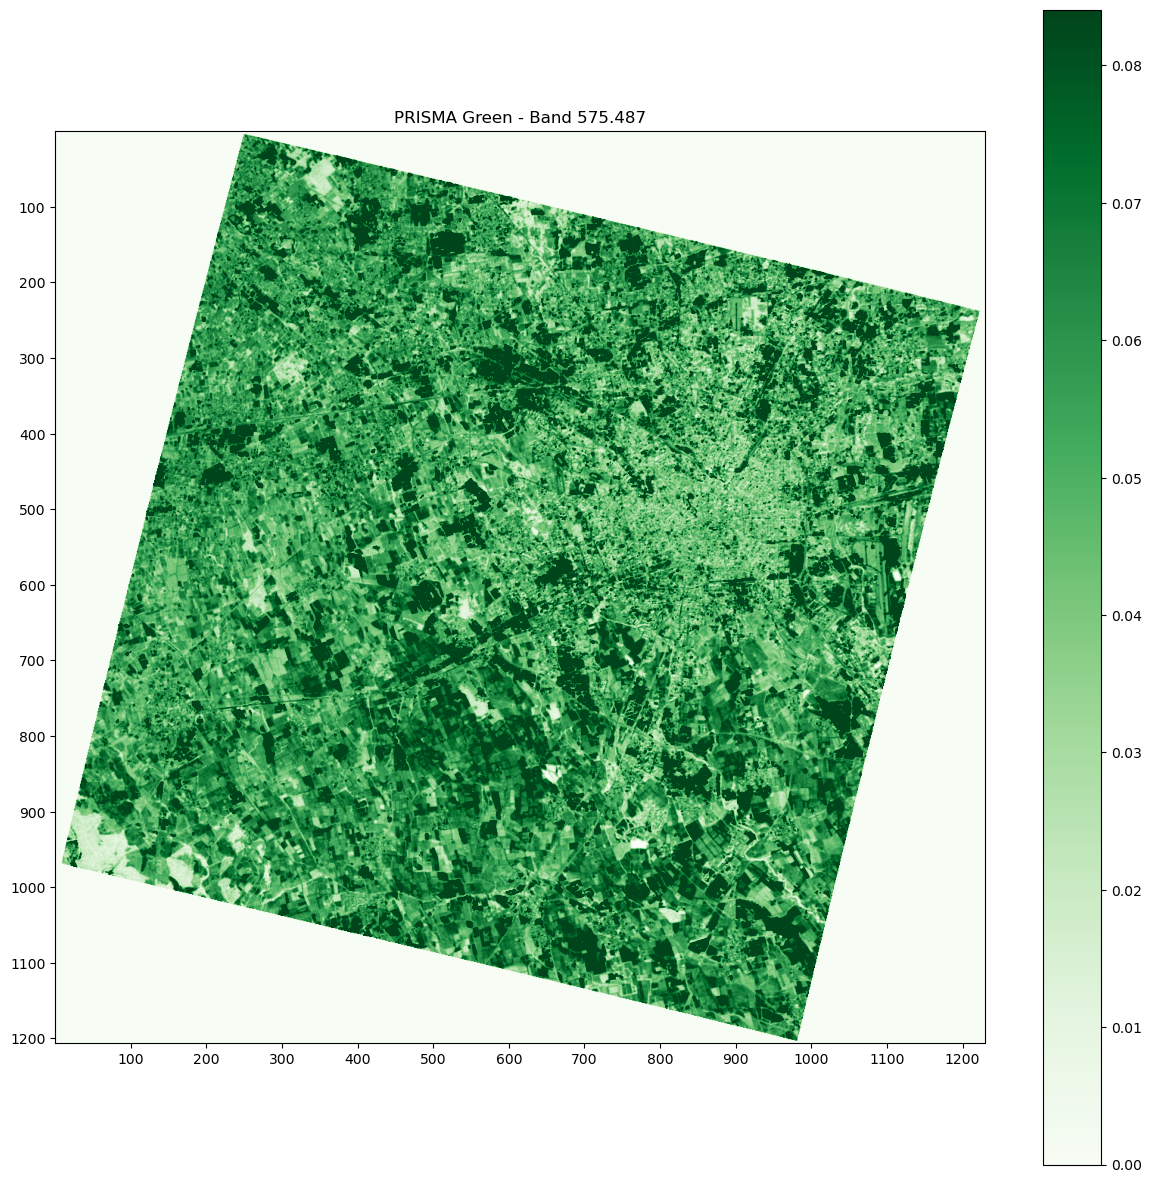

In [28]:
plt.figure(figsize = (15,15))
height, width = green_band_prisma.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(green_band_prisma, cmap="Greens", vmin=-np.quantile(green_band_prisma, 0.1), vmax=np.quantile(green_band_prisma, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title(f'PRISMA Green - Band {vnir_dict[idx_green]:.3f}')
plt.colorbar()

'''Red Band stored in a dedicated array'''
PRISMA_GreenBand = green_band_prisma

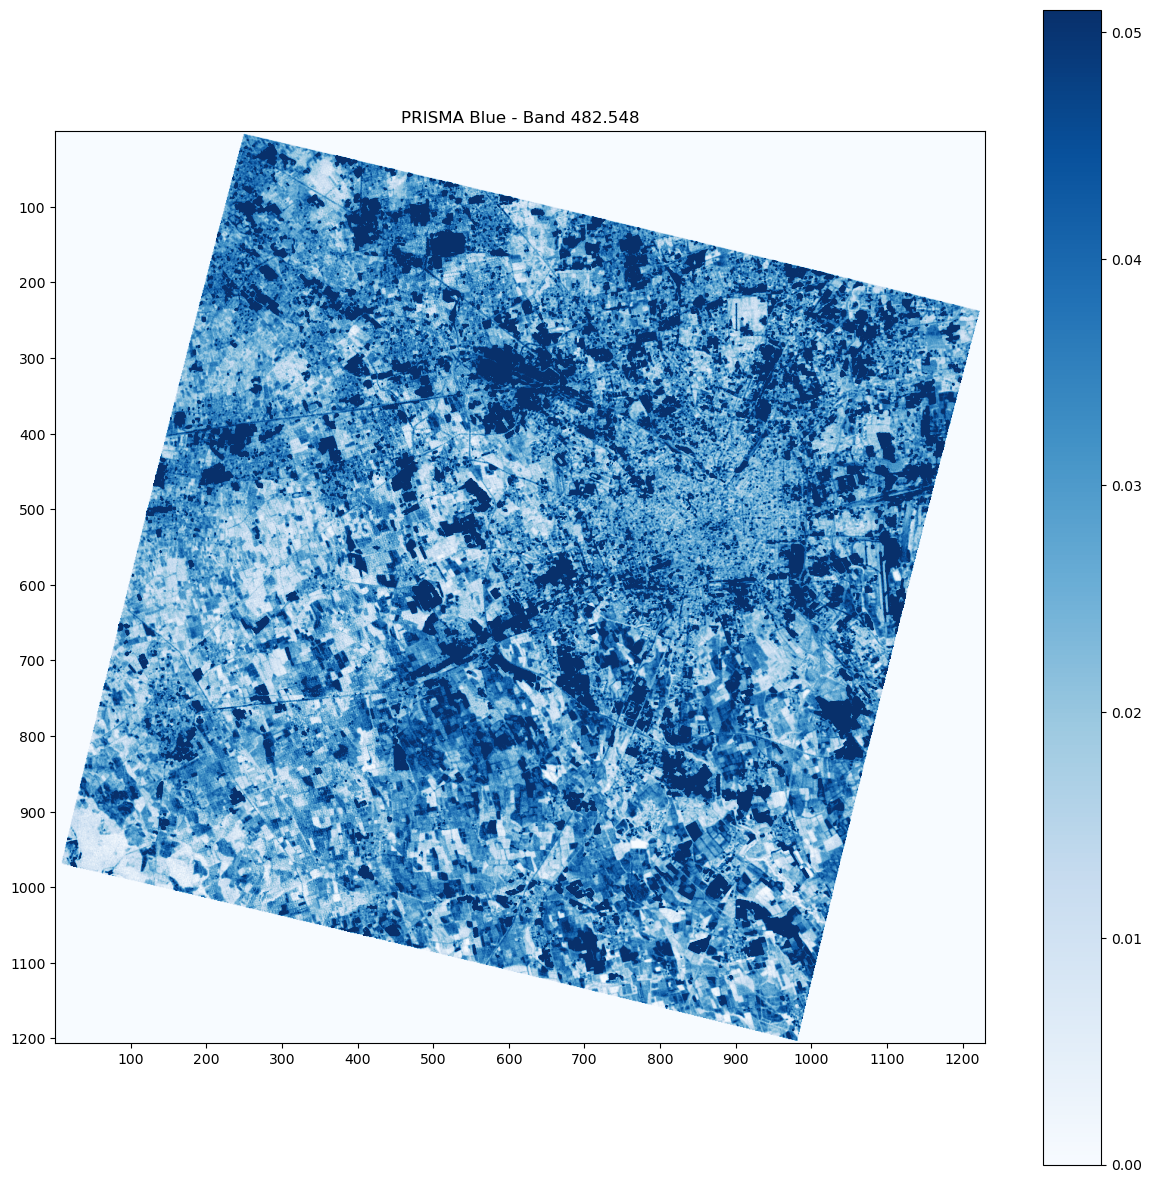

In [29]:
plt.figure(figsize = (15,15))
height, width = blue_band_prisma.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(blue_band_prisma, cmap="Blues", vmin=-np.quantile(blue_band_prisma, 0.1), vmax=np.quantile(blue_band_prisma, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title(f'PRISMA Blue - Band {vnir_dict[idx_blue]:.3f}')
plt.colorbar()

'''Blue Band stored in a dedicated array'''
PRISMA_BlueBand = blue_band_prisma

## 2. <a id='sec2'></a>Importing the pre-processed Sentinel-2 image clipped to PRISMA image extent and resample it at 30m resolution
[Back to top](#TOC_TOP)

Let's import the pre-processed Sentinel-2 image (result of the first notebook `1 - S2_Preprocessing.ipynb`)

To scale Sentinel-2 to reflectance:

In [30]:
S2_scale = 1

with rio.open(selected_image_s2) as src:
    # Read the data from the red, green, and blue bands
    data = src.read() / S2_scale  #indexes=[4, 3, 2]
    # Get the metadata of the source image
    src_meta = src.meta

Define the output desired resolution to resample Sentinel-2 image (30m in this case using bilinear resampling):

In [31]:
dst_resolution = 30

Get transform parameters from the input image:

In [32]:
src.transform[:]

(20.0, 0.0, 488840.0, 0.0, -20.0, 5050440.0, 0.0, 0.0, 1.0)

Update to new resolution the parameters:

In [33]:
dst_meta = src_meta.copy()
dst_meta.update({
    'height': int(src.height * src.transform[0] / dst_resolution),
    'width': int(src.width * src.transform[0] / dst_resolution),
    'transform': rio.Affine(dst_resolution, 0, src.bounds.left, 0, -dst_resolution, src.bounds.top),
    'dtype' : 'float32'
})

Resample using a **bilinear** interpolation with rasterio.reproject (it is possible to change the interpolation method):

In [34]:
resampled_data = np.zeros((src.count, dst_meta['height'], dst_meta['width']), dtype=data.dtype)
reproject(data,resampled_data,src_transform=src.transform,src_crs=src.crs, dst_transform=dst_meta['transform'], dst_crs=src.crs, resampling=Resampling.bilinear);

Save the resampled raster to a 30m GeoTIFF file:

In [35]:
s2_30_path = 'S2_outputs/S2_'+ sel_s2_date.replace('-', '') + '_30m_clip.tif'
print(f"Sentinel-2 image with {dst_resolution}m resolution path --> {s2_30_path}")

Sentinel-2 image with 30m resolution path --> S2_outputs/S2_20230210_30m_clip.tif


In [36]:
with rio.open(s2_30_path, 'w', **dst_meta) as dst:
    dst.write(resampled_data)

CPLE_AppDefinedError: Deleting S2_outputs/S2_20230210_30m_clip.tif failed: Permission denied

Open the resampled Sentinel-2 image:

In [ ]:
sentinel_file = rio.open(s2_30_path)

Sentinel2_NirBand = sentinel_file.read(4)
Sentinel2_RedBand = sentinel_file.read(3)
Sentinel2_GreenBand = sentinel_file.read(2)
Sentinel2_BlueBand = sentinel_file.read(1)

Plot Sentinel-2 Bands:

In [ ]:
plt.figure(figsize = (15,15))
height, width = Sentinel2_NirBand.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(Sentinel2_NirBand, vmin=-np.quantile(Sentinel2_NirBand, 0.1), vmax=np.quantile(Sentinel2_NirBand, 0.9), cmap="Purples")

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title('S2 - NIR band')
plt.colorbar()

In [ ]:
plt.figure(figsize = (15,15))
height, width = Sentinel2_RedBand.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(Sentinel2_RedBand, cmap="Reds", vmin=-np.quantile(Sentinel2_RedBand, 0.1), vmax=np.quantile(Sentinel2_RedBand, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title('S2 - Red band')
plt.colorbar()

In [ ]:
plt.figure(figsize = (15,15))
height, width = Sentinel2_GreenBand.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(Sentinel2_GreenBand, cmap="Greens", vmin=-np.quantile(Sentinel2_GreenBand, 0.1), vmax=np.quantile(Sentinel2_GreenBand, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title('S2 - Green band')
plt.colorbar()

In [ ]:
plt.figure(figsize = (15,15))
height, width = Sentinel2_BlueBand.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(Sentinel2_BlueBand, cmap="Blues", vmin=-np.quantile(Sentinel2_BlueBand, 0.1), vmax=np.quantile(Sentinel2_BlueBand, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title('S2 - Blue band')
plt.colorbar()

### Export NOT coregistered PRISMA imagery (Red-Green-Blue-NIR) - RGBN
This part is not relevant, but these images can be used for comparison to check whether the coregistration is performed correctly.

In [ ]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = 4
kwargs['width'] = vrf_refl.shape[1]
kwargs['height'] = srf_refl.shape[0]
kwargs['dtype'] = 'float32'
kwargs['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs['transform'] = rio.transform.Affine(dst_resolution, src.transform[1],src.transform[2], src.transform[3], -dst_resolution, src.transform[5])

In [ ]:
# # Create a new raster file RGB (change the count number to 3) - Not relevant
# with rio.open('PRISMA_outputs/PR_rgb_'+ sel_prisma_date.replace('-', '') +'_NotCor_30m.tif', 'w', **kwargs) as dst:
#     # Write the RGB data to the raster file
#     dst.write(red_band_prisma, 1)
#     dst.write(green_band_prisma, 2)
#     dst.write(blue_band_prisma, 3)

In [ ]:
# Create a new raster file RGBN
with rio.open('PRISMA_outputs/PR_rgbn_'+ sel_prisma_date.replace('-', '') +'_NotCor_30m.tif', 'w', **kwargs) as dst:
    # Write the RGB data to the raster file
    dst.write(red_band_prisma, 1)
    dst.write(green_band_prisma, 2)
    dst.write(blue_band_prisma, 3)
    dst.write(nir_band_prisma, 4)

## 3. <a id='sec3'></a>Application of GeFolki algorithm
[Back to top](#TOC_TOP)

Now let's apply the EFolki algorithm (this part of code is the same as `GEFOLKI_TP1.ipynb` in the original notebook provided in the GeFolki repository). <br>
This code allows the user to select the desired band to be used for the displacement field estimation. Specifically, the user can select among the Blue, Green, Red, and NIR bands of both PRISMA and Sentinel-2 images.

Firstly, let's define the parameters required by the algorithm. These values yield good results, however, it is possible to tune them (refer to the GeFolki documentation):

In [ ]:
iteration = 4
radius = [100, 100]
rank = 4
level = 5

In [ ]:
bands_dict_PRISMA = {'Blue':PRISMA_BlueBand,
             'Green':PRISMA_GreenBand,
             'Red':PRISMA_RedBand,
             'NIR':PRISMA_NirBand}

bands_dict_S2 = {'Blue':Sentinel2_BlueBand,
             'Green':Sentinel2_GreenBand,
             'Red':Sentinel2_RedBand,
             'NIR':Sentinel2_NirBand}

It is possible to select the S2 and PRISMA bands to be used for coregistration. There are no noticeable differences between the use of differents bands as long as they are corresponding (e.g. PRISMA red band with S2 red band):

In [ ]:
w_band = widgets.RadioButtons(
    options=['Blue', 'Green', 'Red', 'NIR'],
    description='Select band for coregistration:',
    disabled=False,
    value='Red')
w_band

In [ ]:
band_sel = w_band.value
print(f"The band selected for coregistration is: {band_sel}")

The following piece of code applies the algorithm. The result is the estimated horizontal (u) and vertical (v) displacement. (REMINDER: the zeros outside the PRISMA image are intentionally left. Using np.nan gives some issues when processing with GeFolki algorithm):

In [ ]:
#band coregistration
mask_pr = bands_dict_PRISMA[band_sel]>0

PRISMA_Band = bands_dict_PRISMA[band_sel]*mask_pr
Sentinel2_Band = bands_dict_S2[band_sel]
Sentinel2_Band = Sentinel2_Band[:PRISMA_Band.shape[0], :PRISMA_Band.shape[1]]
Sentinel2_Band = Sentinel2_Band*mask_pr

print("Started - GeFolki coregistration")
u, v = EFolki(Sentinel2_Band, PRISMA_Band, iteration=iteration, radius=radius, rank=rank, levels=level)
print("Completed - GeFolki coregistration")

Check `u` and `v` vectors calculated by GeFolki algorithm, to show the tranformation applied:

In [ ]:
print(f"u matrix shape --> {u.shape}")
print(f"v matrix shape --> {v.shape}")

Let's now apply the estimated vectors `u` and `v` to all the NIR and SWIR bands of the PRISMA image. For doing so, let's first initialize two new datacubes (one for NIR, the other for SWIR) that will store the coregistered image. Then, let's fill the new datacubes with the coregistered data (applying the optical flow transformation to each band). Finally, let's concatenate the two datacubes:

In [ ]:
PRISMArecalee_vrf = np.zeros(vrf.shape)
PRISMArecalee_srf = np.zeros(srf.shape)

In [ ]:
for idx, band in enumerate(vn_wvl):
    PRISMArecalee_vrf[:, :, idx] = wrapData(vrf_refl[:, :, idx], u, v)

In [ ]:
for idx, band in enumerate(sw_wvl):
    PRISMArecalee_srf[:, :, idx] = wrapData(srf_refl[:, :, idx], u, v)

Masks for the coregistered and not coregistered imagery:

In [ ]:
# Mask for coregistered imagery
outside_mask_coreg = np.amax(PRISMArecalee_vrf, axis=2).astype(float)
outside_mask_coreg[outside_mask_coreg != 0] = 1
outside_mask_coreg[outside_mask_coreg == 0] = np.nan
plt.imshow(outside_mask_coreg)
plt.title("Mask PRISMA - Coregistered image");

In [ ]:
# Mask for NOT coregistered imagery
outside_mask_not_coreg = np.amax(vrf, axis=2).astype(float)
outside_mask_not_coreg[outside_mask_not_coreg != 0] = 1
outside_mask_not_coreg[outside_mask_not_coreg == 0] = np.nan
plt.imshow(outside_mask_not_coreg)
plt.title("Mask PRISMA - Not coregistered image");

In [ ]:
# Create a meshgrid for the coordinates
X, Y = np.meshgrid(np.arange(0, v.shape[1]), np.arange(0, v.shape[0]))

#Remove quivers outside the image region
X = X * outside_mask_coreg
Y = Y * outside_mask_coreg

#Keep every 40 quivers to not have too many of them
skip = 40
X_subset = X[::skip, ::skip]
Y_subset = Y[::skip, ::skip]
u_subset = -u[::skip, ::skip]
v_subset = v[::skip, ::skip]
# Compute the vector length
uv_length = np.sqrt(u_subset**2 + v_subset**2)

fig, ax = plt.subplots(figsize=(15, 15))
widths = np.linspace(0, 100, X.size)
ax.quiver(X_subset, Y_subset, u_subset, v_subset, uv_length, cmap='jet', headaxislength=3)
plt.title("GeFolki u and v vectors - Displacement")
plt.show()

Mask the u and v vector in the outer the PRISMA image:

In [ ]:
u_masked =  u * outside_mask_coreg
v_masked = v * outside_mask_coreg

In [ ]:
plt.hist(u_masked.flatten());
plt.title("Histogram of masked u matrix");

In [ ]:
plt.hist(v_masked.flatten());
plt.title("Histogram of masked v matrix");

In [ ]:
print(f"Mean of u: {np.nanmean(u_masked):.2f} | STD: {np.nanstd(u_masked):.2f} | Median: {np.nanmedian(u_masked):.2f}")
print(f"Mean of v: {np.nanmean(v_masked):.2f} | STD: {np.nanstd(v_masked):.2f} | Median: {np.nanmedian(v_masked):.2f}")

The Geolfki algorithm is applied again (using the Red band only, but whatever band can be used), in order to check whether the coregistration applied provided a good result. 
The algorithm is applied between a S2 band and a coregistrered PRISMA band.

Some statistics are provided to check the quality of coregistration.

In [ ]:
print("Started - GeFolki coregistration")
u_check, v_check = EFolki(Sentinel2_Band, PRISMArecalee_srf[:, :, 32], iteration=iteration, radius=radius, rank=rank, levels=level) #32 is red band index - CHANGE INDEX IF WANT TO TEST WITH OTHER BANDS
print("Completed - GeFolki coregistration")

In [ ]:
u_check_masked =  u_check * outside_mask_coreg
v_check_masked = v_check * outside_mask_coreg

In [ ]:
plt.hist(u_check_masked.flatten());
plt.title("Histogram of masked u matrix - Reapplied GeFolki");

In [ ]:
plt.hist(v_check_masked.flatten());
plt.title("Histogram of masked v matrix - Reapplied GeFolki");

In [ ]:
print(f"New coregistration - Mean of u: {np.nanmean(u_check_masked):.2f} | STD: {np.nanstd(u_check_masked):.2f} | Median: {np.nanmedian(u_check_masked):.2f}")
print(f"New coregistration - Mean of v: {np.nanmean(v_check_masked):.2f} | STD: {np.nanstd(v_check_masked):.2f} | Median: {np.nanmedian(v_check_masked):.2f}")

## 4. <a id='sec4'></a>Exporting the *co-registered* PRISMA image and the original *NOT co-registered* PRISMA image (single bands/RGB composite/NIR bands/all NIR and SWIR bands)
[Back to top](#TOC_TOP)

In [ ]:
#Create a folder for coregistered images
if not os.path.exists(r'PRISMA_outputs/coregistered'):
    os.makedirs(r'PRISMA_outputs/coregistered')

### Export coregistered imagery (one image for each band)

Let's now export the **coregistered** PRISMA bands with `rasterio` (not relevant but code is provided to export bands separately):

In [ ]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = 1
kwargs['width'] = PRISMArecalee_vrf.shape[1]
kwargs['height'] = PRISMArecalee_vrf.shape[0]
kwargs['dtype'] = 'float32'
kwargs['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs['transform'] = rio.transform.Affine(dst_resolution, src.transform[1],src.transform[2], src.transform[3], -dst_resolution, src.transform[5])

In [ ]:
# for i in range(0, PRISMArecalee_vrf.shape[2]):
#     name = 'vnir_b'+ str(vnir_keys[i]) + '_' + sel_prisma_date.replace('-', '') + '_30m'+'.tiff'
#     with rio.open(os.path.join(r'PRISMA_outputs/coregistered', name), 'w', **kwargs) as dst:
#         dst.write_band(1, PRISMArecalee_vrf[:, :, i].astype(rio.float32))

In [ ]:
# for i in range(0, PRISMArecalee_srf.shape[2]):
#     name = 'swir_b' + str(swir_keys[i]) + '_' + sel_prisma_date.replace('-', '') + '_30m'+'.tiff'
#     with rio.open(os.path.join(r'PRISMA_outputs/coregistered', name), 'w', **kwargs) as dst:
#         dst.write_band(1, PRISMArecalee_srf[:, :, i].astype(rio.float32))

### Export complete coregistered imagery (*useful for spectral signature plotting*)
**NOTE**: also bands with all zero values are kept for completeness. They can be removed easily when they are imported. The zero bands are removed in the following notebooks when the image is imported.

In [ ]:
PRISMArecalee_vrf_sorted = np.flip(PRISMArecalee_vrf, axis=2)
PRISMArecalee_srf_sorted = np.flip(PRISMArecalee_srf, axis=2)
PRISMArecalee_sorted = np.dstack((PRISMArecalee_vrf_sorted, PRISMArecalee_srf_sorted))
PRISMArecalee_sorted = np.moveaxis(PRISMArecalee_sorted, -1, 0)

In [ ]:
PRISMArecalee_sorted.shape

In [ ]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = PRISMArecalee_sorted.shape[0]
kwargs['width'] = PRISMArecalee_sorted.shape[2]
kwargs['height'] = PRISMArecalee_sorted.shape[1]
kwargs['dtype'] = 'float32'
kwargs['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs['transform'] = rio.transform.Affine(dst_resolution, src.transform[1],src.transform[2], src.transform[3], -dst_resolution, src.transform[5])

In [ ]:
with rio.open('PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif', 'w', **kwargs) as dst:
    dst.write(PRISMArecalee_sorted.astype(rio.float32))

### Export complete NOT coregistered imagery (*useful for spectral signature plotting*)
**NOTE**: also bands with all zero values are kept for completeness. They can be removed easily when they are imported. The zero bands are removed in the following notebooks when the image is imported.

In [ ]:
vrf_refl_sorted = np.flip(vrf_refl, axis=2)
srf_refl_sorted = np.flip(srf_refl, axis=2)
PRISMA_sorted = np.dstack((vrf_refl_sorted, srf_refl_sorted))
PRISMA_sorted = np.moveaxis(PRISMA_sorted, -1, 0)

In [ ]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = PRISMA_sorted.shape[0]
kwargs['width'] = PRISMA_sorted.shape[2]
kwargs['height'] = PRISMA_sorted.shape[1]
kwargs['dtype'] = 'float32'
kwargs['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs['transform'] = rio.transform.Affine(dst_resolution, src.transform[1],src.transform[2], src.transform[3], -dst_resolution, src.transform[5])

In [ ]:
# with rio.open('PRISMA_outputs/PR_'+ sel_prisma_date.replace('-', '') + '_NotCor_30m.tif', 'w', **kwargs) as dst:
#     dst.write(PRISMA_sorted.astype(rio.float32))

### Export coregistered PRISMA imagery VNIR bands (*useful for pansharpening*)

Export only the coregistered VNIR cube. This may be useful for pansharpening, since the VNIR bands cover the same spectrum as the PAN band.

In [ ]:
PRISMArecalee_vrf_sorted = np.moveaxis(PRISMArecalee_vrf_sorted, -1, 0)

In [ ]:
PRISMArecalee_vrf_sorted.shape

In [ ]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = PRISMArecalee_vrf_sorted.shape[0]
kwargs['width'] = PRISMArecalee_vrf_sorted.shape[2]
kwargs['height'] = PRISMArecalee_vrf_sorted.shape[1]
kwargs['dtype'] = 'float32'
kwargs['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs['transform'] = rio.transform.Affine(dst_resolution, src.transform[1],src.transform[2], src.transform[3], -dst_resolution, src.transform[5])

In [ ]:
with rio.open('PRISMA_outputs/coregistered/PR_VNIR_'+ sel_prisma_date.replace('-', '') + '_30m.tif', 'w', **kwargs) as dst:
    dst.write(PRISMArecalee_vrf_sorted.astype(rio.float32))

### Export coregistered PRISMA imagery Red-Green-Blue-NIR (RGBN)
Export the PRISMA image with RGBN bands.

In [ ]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = 4
kwargs['width'] = PRISMArecalee_vrf.shape[1]
kwargs['height'] = PRISMArecalee_vrf.shape[0]
kwargs['dtype'] = 'float32'
kwargs['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs['transform'] = rio.transform.Affine(dst_resolution, src.transform[1],src.transform[2], src.transform[3], -dst_resolution, src.transform[5])

In [ ]:
# # Create a new raster file RGB
# with rio.open('rgb_PRISMA_coreg_image.tif', 'w', **kwargs) as dst:
#     # Write the RGB data to the raster file
#     dst.write(red_band, 1)
#     dst.write(green_band, 2)
#     dst.write(blue_band, 3)

In [ ]:
red_band = PRISMArecalee_vrf[:, :, idx_red_prisma]
green_band = PRISMArecalee_vrf[:, :, idx_green_prisma]
blue_band = PRISMArecalee_vrf[:, :, idx_blue_prisma]
nir_band = PRISMArecalee_vrf[:, :, idx_nir_prisma]

In [ ]:
# Create a new raster file RGBN
with rio.open('PRISMA_outputs/coregistered/PR_rgbn_'+ sel_prisma_date.replace('-', '') + '_30m.tif', 'w', **kwargs) as dst:
    # Write the RGB data to the raster file
    dst.write(red_band.astype(rio.float32), 1)
    dst.write(green_band.astype(rio.float32), 2)
    dst.write(blue_band.astype(rio.float32), 3)
    dst.write(nir_band.astype(rio.float32), 4)

In [ ]:
# Open the TIFF file in read mode
plt.figure(figsize = (6,6))
with rio.open('PRISMA_outputs/coregistered/PR_rgbn_'+ sel_prisma_date.replace('-', '') + '_30m.tif') as src:
    rgb = src.read(indexes = [1,2,3])
    # Plot the image
    plt.imshow(rgb.transpose(1, 2, 0)*5)
    plt.show()

---

## Additional visualizations coregistered imagery
This part is related to visualization and comparison of Sentinel-2 and PRISMA imagery, both coregistered and not coregistered.

Define the coordinates for limit the plot bounding box:

In [ ]:
#Bounding box
xmin=400
xmax=600
ymin=400
ymax=600

In [ ]:
# Open the two tif files
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/coregistered/PR_rgbn_'+ sel_prisma_date.replace('-', '') + '_30m.tif') as src2:
    # Read the data from the two files
    data1 = src1.read(indexes=[3, 2, 1])
    data2 = src2.read(indexes=[1, 2, 3])

    # create a new figure object with two subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
    # Plot the two layers on top of each other
    ax1.imshow(data1.transpose(1, 2, 0)*2)  # multiplied to adjust brightness just visually
    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax])
    show_hist(data1, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram PRISMA", ax=ax2)
    
    ax3.imshow(data2.transpose(1, 2, 0)*3) # multiplied to adjust brightness just visually
    ax3.set_xlim([xmin, xmax])
    ax3.set_ylim([ymin, ymax])
    show_hist(data2, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram Sentinel-2", ax=ax4)

The plot illustrates the impact of coregistration, with displacement arrows indicating areas of higher deformation and displacement (arrows not in scale):

In [ ]:
x_max_pl = 0
x_min_pl = 1000
y_max_pl = 0
y_min_pl = 1000

# Open the two tif files
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/PR_rgbn_'+sel_prisma_date.replace('-', '')+'_NotCor_30m.tif') as src2:
    
    # Read the data from the two files
    data2 = src2.read(1)*2
    data1 = src1.read(indexes=[3])[:, :data2.shape[0], :data2.shape[1]]

    C = np.dstack((data1.reshape(data1.shape[1], data1.shape[2]), data2, data1.reshape(data1.shape[1], data1.shape[2])))
    pl.figure(figsize=(25,25))
    pl.imshow(C*2)
    pl.quiver(X_subset, Y_subset, u_subset, v_subset, uv_length, cmap='jet', clim=(0, 6),  linewidths=widths, headwidth=2, headlength=4, alpha=0.5)
    # plt.xlim([x_min_pl, x_max_pl])
    # plt.ylim([y_min_pl, y_max_pl])
    pl.title('Before Sentinel-2 - PRISMA Coregistration')

In [ ]:
# Open the two tif files
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/coregistered/PR_rgbn_'+sel_prisma_date.replace('-', '')+'_30m.tif') as src2:
    
    # Read the data from the two files
    data2 = src2.read(1)*2
    data1 = src1.read(indexes=[3])[:, :data2.shape[0], :data2.shape[1]]
    
    C = np.dstack((data1.reshape(data1.shape[1], data1.shape[2]), data2, data1.reshape(data1.shape[1], data1.shape[2])))
    pl.figure(figsize=(25,25))
    pl.imshow(C*2)
    # plt.xlim([x_min_pl, x_max_pl])
    # plt.ylim([y_min_pl, y_max_pl])
    pl.title('After Sentinel-2 - PRISMA Coregistration')

-----

### Optional visualization using Canny Edge Detection

In [ ]:
from skimage import feature
from skimage import filters

## Canny Edge Detection method
Reference at this link: [Skimage Canny Edge Detector](https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html).
It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

The Canny has three adjustable parameters: the width of the Gaussian (the noisier the image, the greater the width), and the low and high threshold for the hysteresis thresholding.

In [ ]:
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/PR_rgbn_'+sel_prisma_date.replace('-', '')+'_NotCor_30m.tif') as src2:
    data1 = src1.read(indexes=[3])
    data2 = src2.read(1)
    edges1 = feature.canny(data1.squeeze())
    edges2 = feature.canny(data2.squeeze())

    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.imshow(data1.transpose(1, 2, 0), cmap='binary')  # multiplied to adjust brightness
    cmap1 = plt.cm.Reds
    cmap2 = plt.cm.Blues
    im1 = ax.imshow(edges1, cmap=cmap1, alpha=1, vmin=0, vmax=1.4)
    im2 = ax.imshow(edges2, cmap=cmap2, alpha=0.7, vmin=0, vmax=1.4)
    plt.xlim([x_min_pl, x_max_pl])
    plt.ylim([y_min_pl, y_max_pl])
    ax.set_title('Canny Edge Detector - Before Sentinel-2 - PRISMA Coregistration', fontsize=12)
    
    plt.show()

In [ ]:
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/coregistered/PR_rgbn_'+sel_prisma_date.replace('-', '')+'_30m.tif') as src2:
    data1 = src1.read(indexes=[3])  #red 3
    data2 = src2.read(1)
    edges1 = feature.canny(data1.squeeze(), sigma=1)
    edges2 = feature.canny(data2.squeeze(), sigma=0.7)

    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.imshow(data1.transpose(1, 2, 0), cmap='binary')  # multiplied to adjust brightness
    cmap1 = plt.cm.Reds
    cmap2 = plt.cm.Blues
    im1 = ax.imshow(edges1, cmap=cmap1, alpha=1, vmin=0, vmax=1.4)
    im2 = ax.imshow(edges2, cmap=cmap2, alpha=0.7, vmin=0, vmax=1.4)
    plt.xlim([x_min_pl, x_max_pl])
    plt.ylim([y_min_pl, y_max_pl])
    ax.set_title('Canny Edge Detector - After Sentinel-2 - PRISMA Coregistration', fontsize=12)
    
    plt.show()

### Optional visualization using Sobel Mask Edge Detector

Reference at this link: [Skimage Sobel Mask Edge Detector](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html).

In [ ]:
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/PR_rgbn_'+sel_prisma_date.replace('-', '')+'_NotCor_30m.tif') as src2:
    data1 = src1.read(indexes=[3])
    data2 = src2.read(1)
    edges1 = filters.sobel(data1.squeeze())
    edges2 = filters.sobel(data2.squeeze())
    
    p2_1, p98_1 = np.percentile(edges1, (2, 98))
    p2_2, p98_2 = np.percentile(edges2, (2, 98))
    
    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    
    ax.imshow(edges1*2, cmap='Reds', alpha=1, vmin=p2_1, vmax=p98_1)
    ax.imshow(edges2, cmap='Blues', alpha=0.7, vmin=p2_2, vmax=p98_2)
    plt.xlim([x_min_pl, x_max_pl])
    plt.ylim([y_min_pl, y_max_pl])
    ax.set_title('Sobel Mask Edge Detector - Before Sentinel-2 - PRISMA Coregistration', fontsize=12)

In [ ]:
with rio.open('S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_30m_clip.tif') as src1, rio.open('PRISMA_outputs/coregistered/PR_rgbn_'+sel_prisma_date.replace('-', '')+'_30m.tif') as src2:
    data1 = src1.read(indexes=[3])
    data2 = src2.read(1)
    edges1 = filters.sobel(data1.squeeze())
    edges2 = filters.sobel(data2.squeeze())
    
    p2_1, p98_1 = np.percentile(edges1, (2, 98))
    p2_2, p98_2 = np.percentile(edges2, (2, 98))
    
    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    
    ax.imshow(edges1*2, cmap='Reds', alpha=1, vmin=p2_1, vmax=p98_1)
    ax.imshow(edges2, cmap='Blues', alpha=0.7, vmin=p2_2, vmax=p98_2)
    plt.xlim([x_min_pl, x_max_pl])
    plt.ylim([y_min_pl, y_max_pl])
    ax.set_title('Sobel Mask Edge Detector - After Sentinel-2 - PRISMA Coregistration', fontsize=20)

## 5. <a id='sec5'></a>Panchromatic coregistration and export
[Back to top](#TOC_TOP)

This part of the notebook allows for:
- Exporting panchromatic band NOT coregistered
- Upsampling Sentinel-2 imagery from 20m to 5m for panchromatic coregistration
- Coregistering panchromatic image applying the GeFolki algorithm to Sentinel-2 and PRISMA panchromatic band both at 5m resolution

**TESTED**: upscaled previously calculated `u` and `v` displacement (for 30m resolution) interpolating linearly the u and v values to 5m resolution. This is necessary to have the same array dimensions and apply the transformation to a panchromatic image. It didn't produce a good result.

In [ ]:
pan = np.array(f['HDFEOS']['SWATHS']['PRS_L2D_PCO']['Data Fields']['Cube'][:])
pan

In [ ]:
pan.shape

In [ ]:
plt.figure(figsize = (15,15))
height, width = pan.shape
extent = [0, width, height, 0]  # left, right, bottom, top
plt.imshow(pan, cmap="binary", vmin=-np.quantile(pan, 0.1), vmax=np.quantile(pan, 0.9), extent=extent)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=width//100+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=height//100+1))
plt.title(f'PRISMA Panchromatic band')
plt.xticks(rotation=45, fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.colorbar()

In [ ]:
kwargs_pan = {}
kwargs_pan['driver'] = 'GTiff'
kwargs_pan['dtype'] = 'float32'
kwargs_pan['count'] = 1
kwargs_pan['width'] = pan.shape[1]
kwargs_pan['height'] = pan.shape[0]
kwargs_pan['dtype'] = 'float32'
kwargs_pan['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs_pan['transform'] = rio.transform.Affine(5, src.transform[1],src.transform[2], src.transform[3], -5, src.transform[5])

In [ ]:
# Create a new raster file RGBN
with rio.open('PRISMA_outputs/PR_pan_'+sel_prisma_date.replace('-', '')+'_NotCor_5m.tif', 'w', **kwargs_pan) as pan_dst:
    # Write the RGB data to the raster file
    pan_dst.write(pan.astype(rio.float32), 1)

In [ ]:
# Open the TIFF file in read mode
plt.figure(figsize = (15,15))
with rio.open('PRISMA_outputs/PR_pan_'+sel_prisma_date.replace('-', '')+'_NotCor_5m.tif') as pan_src:
    pan_data = pan_src.read()
    # Plot the image
    plt.imshow(pan_data.transpose(1, 2, 0)*5, cmap='gray')
    plt.show()

### Upscale Sentinel-2 imager to 5m and apply GeFolki algorithm to panchromatic PRISMA band

To scale Sentinel-2 to reflectance:

In [ ]:
S2_scale = 1

with rio.open(selected_image_s2) as src:
    # Read the data from the red, green, and blue bands
    data = src.read() / S2_scale  #indexes=[4, 3, 2]
    # Get the metadata of the source image
    src_meta = src.meta

Define the output desired resolution:

In [ ]:
s2_5m_resolution = 5

Get transform parameters from the input image:

In [ ]:
src.transform[:]

Update to new resolution the parameters:

In [ ]:
dst_meta = src_meta.copy()
dst_meta.update({
    'height': int(src.height * src.transform[0] / s2_5m_resolution),
    'width': int(src.width * src.transform[0] / s2_5m_resolution),
    'transform': rio.Affine(s2_5m_resolution, 0, src.bounds.left, 0, -s2_5m_resolution, src.bounds.top),
    'dtype' : 'float32'
})

Resample using a **bilinear** interpolation with rasterio.reproject (it is possible to change the interpolation method):

In [ ]:
resampled_data = np.zeros((src.count, dst_meta['height'], dst_meta['width']), dtype=data.dtype)
reproject(data,resampled_data,src_transform=src.transform,src_crs=src.crs, dst_transform=dst_meta['transform'], dst_crs=src.crs, resampling=Resampling.bilinear);

Save the resampled raster to a 5m resolution GeoTIFF file:

In [ ]:
s2_5_path = 'S2_outputs/S2_'+sel_s2_date.replace('-', '')+'_5m_clip.tif'

In [ ]:
with rio.open(s2_5_path, 'w', **dst_meta) as dst:
    dst.write(resampled_data.astype(rio.float32))

In [ ]:
with rio.open(s2_5_path) as s2_5m_src:
    s2_5m_src_data = s2_5m_src.read(1)

Check if the arrays dimensions are compatible:

In [ ]:
print(f"The shape of PRISMA panchromatic image is: {pan.shape}")
print(f"The shape of upscaled 5m resolution Sentinel-2 image band is: {s2_5m_src_data.shape}")
print("---------------------")
if pan.shape == s2_5m_src_data.shape:
    print("Dimensions are the same")
else:
    print("Array dimensions are different. Applying a clip.")
    # Crop the Sentinel-2 image to match the shape of the PRISMA image
    s2_5m_src_data2 = s2_5m_src_data[:pan.shape[0], :pan.shape[1]]
    # Check the shape of the cropped Sentinel-2 image
    print(f"The shape of the new cropped Sentinel-2 image band is: {s2_5m_src_data2.shape}")

In [ ]:
iteration = 4
radius = [100, 100]
rank = 4
level = 5

Applying GeFolki algorithm to panchromatic band. This may take a while to be concluded!

In [ ]:
print("Started - GeFolki coregistration")
u, v = EFolki(s2_5m_src_data2, pan, iteration=iteration, radius=radius, rank=rank, levels=level)
print("Completed - GeFolki coregistration")

In [ ]:
sub_size=40 # To subset quivers

# Create a meshgrid for the coordinates
X, Y = np.meshgrid(np.arange(0, v.shape[1]), np.arange(0, v.shape[0]))

skip = 300
X_subset = X[::skip, ::skip]
Y_subset = Y[::skip, ::skip]
u_subset = -u[::skip, ::skip]
v_subset = v[::skip, ::skip]
# Compute the vector length
uv_length = np.sqrt(u_subset**2 + v_subset**2)

fig, ax = plt.subplots(figsize=(15, 15))
widths = np.linspace(0, 100, X.size)
ax.quiver(X_subset, Y_subset, u_subset, v_subset, uv_length, cmap='jet', clim=(0, 6),  linewidths=widths, headwidth=2, headlength=4)
plt.show()

Let's now apply the estimated vectors `u` and `v` to panchromatic band of PRISMA image. For doing so, let's first initialize again the PAN cube that will store the coregistered image. Then, let's fill the new datacube with the coregistered data (applying the optical flow transformation):

In [ ]:
PRISMArecalee_pan = np.zeros(pan.shape)

In [ ]:
PRISMArecalee_pan = wrapData(pan, u, v)

In [ ]:
kwargs_pan = {}
kwargs_pan['driver'] = 'GTiff'
kwargs_pan['dtype'] = 'float32'
kwargs_pan['count'] = 1
kwargs_pan['width'] = PRISMArecalee_pan.shape[1]
kwargs_pan['height'] = PRISMArecalee_pan.shape[0]
kwargs_pan['dtype'] = 'float32'
kwargs_pan['crs'] = rio.crs.CRS.from_epsg(32632)
kwargs_pan['transform'] = rio.transform.Affine(5, src.transform[1],src.transform[2], src.transform[3], -5, src.transform[5])

In [ ]:
# Create a new raster file RGBN
with rio.open('PRISMA_outputs/coregistered/PR_pan_'+sel_prisma_date.replace('-', '')+'_5m.tif', 'w', **kwargs_pan) as pan_dst:
    # Write the RGB data to the raster file
    pan_dst.write(PRISMArecalee_pan.astype(rio.float32), 1)

In [ ]:
# Open the TIFF file in read mode
plt.figure(figsize = (15,15))
with rio.open('PRISMA_outputs/coregistered/PR_pan_'+sel_prisma_date.replace('-', '')+'_5m.tif') as pan_src:
    pan_data = pan_src.read()
    # Plot the image
    plt.imshow(pan_data.transpose(1, 2, 0))
    plt.show()

In [ ]:
# Open the two tif files
with rio.open(s2_5_path) as src1, rio.open('PRISMA_outputs/PR_pan_'+sel_prisma_date.replace('-', '')+'_NotCor_5m.tif') as src2:
    # Read the data from the two files
    data = src2.read(1)
    data2 = (data - np.min(data)) / (np.max(data) - np.min(data))
    data = src1.read(indexes=[3])
    data1 = (data - np.min(data)) / (np.max(data) - np.min(data))
    C = np.dstack((data1.squeeze()[:pan.shape[0], :pan.shape[1]], data2, data1.squeeze()[:pan.shape[0], :pan.shape[1]]))
    pl.figure(figsize=(25,25))
    pl.imshow(C)
    plt.xlim([3000, 4000])
    plt.ylim([3000, 4000])
    pl.quiver(X_subset, Y_subset, u_subset, v_subset, uv_length, cmap='jet', clim=(0, 6),  linewidths=widths, headwidth=2, headlength=4, alpha=0.5)
    pl.title('Before Sentinel-2 - PRISMA Coregistration')

In [ ]:
s2_5_path

In [ ]:
# Open the two tif files
with rio.open(s2_5_path) as src1, rio.open('PRISMA_outputs/coregistered/PR_pan_'+sel_prisma_date.replace('-', '')+'_5m.tif') as src2:
    # Read the data from the two files
    data = src2.read(1)
    data2 = (data - np.min(data)) / (np.max(data) - np.min(data))
    data = src1.read(indexes=[3])
    data1 = (data - np.min(data)) / (np.max(data) - np.min(data))
    C = np.dstack((data1.squeeze()[:pan.shape[0], :pan.shape[1]], data2, data1.squeeze()[:pan.shape[0], :pan.shape[1]]))
    pl.figure(figsize=(25,25))
    pl.imshow(C)
    plt.xlim([3000, 4000])
    plt.ylim([3000, 4000])
    pl.title('After Sentinel-2 - PRISMA Coregistration')

In [ ]:
with rio.open(s2_5_path) as src1, rio.open('PRISMA_outputs/PR_pan_'+sel_prisma_date.replace('-', '')+'_NotCor_5m.tif') as src2:
    data1 = src1.read(indexes=[1])
    data2 = src2.read(1)
    edges1 = feature.canny(data1.squeeze())
    edges2 = feature.canny(data2.squeeze())

    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.imshow(data1.transpose(1, 2, 0), cmap='binary')  # multiplied to adjust brightness
    cmap1 = plt.cm.Reds
    cmap2 = plt.cm.Blues
    im1 = ax.imshow(edges1, cmap=cmap1, alpha=1)
    im2 = ax.imshow(edges2, cmap=cmap2, alpha=0.7)
    plt.xlim([3000, 4000])
    plt.ylim([3000, 4000])
    ax.set_title('Canny Edge Detector - Before Sentinel-2 - PRISMA Coregistration', fontsize=12)
    
    plt.show()

In [ ]:
with rio.open(s2_5_path) as src1, rio.open('PRISMA_outputs/coregistered/PR_pan_'+sel_prisma_date.replace('-', '')+'_5m.tif') as src2:
    data1 = src1.read(indexes=[3])  #red 3
    data2 = src2.read(1)
    edges1 = feature.canny(data1.squeeze(), sigma=1)
    edges2 = feature.canny(data2.squeeze(), sigma=0.7)

    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.imshow(data1.transpose(1, 2, 0), cmap='binary')  # multiplied to adjust brightness
    cmap1 = plt.cm.Reds
    cmap2 = plt.cm.Blues
    im1 = ax.imshow(edges1, cmap=cmap1, alpha=1)
    im2 = ax.imshow(edges2, cmap=cmap2, alpha=0.7)
    plt.xlim([3000, 4000])
    plt.ylim([3000, 4000])
    ax.set_title('Canny Edge Detector - After Sentinel-2 - PRISMA Coregistration', fontsize=12)
    
    plt.show()

### Clip PRISMA Imagery over the study area

In [ ]:
import geopandas as gpd
from rasterio.mask import mask

# Load the GeoPackage vector file
study_area_path = "study_area/study_area.gpkg"
study_area = gpd.read_file(study_area_path)

### For all bands

In [ ]:
# Define the paths to the GeoTIFF and Geopackage files
input_geotiff = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
output_geotiff = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'

In [ ]:
clip_image_study_area(input_geotiff, output_geotiff, study_area)

### For RGBN bands

In [ ]:
# Define the paths to the GeoTIFF and Geopackage files
input_geotiff_rgbn = 'PRISMA_outputs/coregistered/PR_rgbn_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
output_geotiff_rgbn = 'PRISMA_outputs/coregistered/PR_rgbn_'+ sel_prisma_date.replace('-', '') + '_30m.tif'

In [ ]:
clip_image_study_area(input_geotiff_rgbn, output_geotiff_rgbn, study_area)

### For VNIR bands

In [ ]:
# Define the paths to the GeoTIFF and Geopackage files
input_geotiff_rgbn = 'PRISMA_outputs/coregistered/PR_VNIR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
output_geotiff_rgbn = 'PRISMA_outputs/coregistered/PR_VNIR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'

In [ ]:
clip_image_study_area(input_geotiff_rgbn, output_geotiff_rgbn, study_area)

### For Pan band

In [ ]:
# Define the paths to the GeoTIFF and Geopackage files
input_geotiff_pan = 'PRISMA_outputs/coregistered/PR_pan_'+sel_prisma_date.replace('-', '')+'_5m.tif'
output_geotiff_pan = 'PRISMA_outputs/coregistered/PR_pan_'+sel_prisma_date.replace('-', '')+'_5m.tif'

In [ ]:
clip_image_study_area(input_geotiff_pan, output_geotiff_pan, study_area)